- We code that part in this notebook

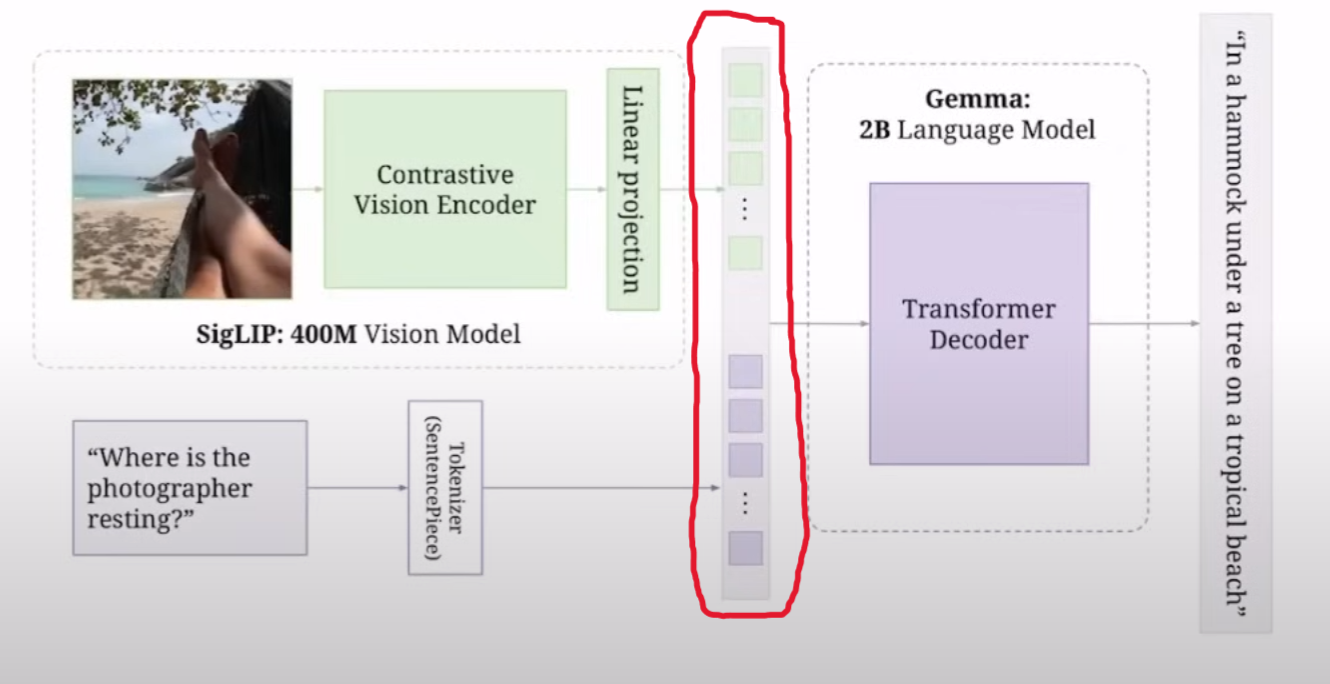

In [1]:
from typing import Dict, List, Optional, Union, Tuple, Iterable
import numpy as np
from PIL import Image
import torch

In [2]:
IMAGENET_STANDARD_MEAN = [0.5, 0.5, 0.5]
IMAGENET_STANDARD_STD = [0.5, 0.5, 0.5]

## Helpful Functions

In [3]:
def add_image_tokens_to_prompt(prefix_prompt, bos_token, image_seq_len, image_token):
    return f"{image_token * image_seq_len}{bos_token}{prefix_prompt}\n"

In [4]:
def rescale(image: np.ndarray, scale: float, dtype: np.dtype = np.float32) -> np.ndarray:
    rescaled_img = (image * scale).astype(dtype)
    return rescaled_img

In [5]:
def resize(image: Image, size: Tuple[int, int],
           resample: Image.Resampling=None,
           reducing_gap: Optional[int]=None) -> np.ndarray:
    h, w = size
    resized_img = image.resize((w, h), resample=resample,
                               reducing_gap=reducing_gap)
    return resized_img

In [6]:
def normalize(
    image: np.ndarray,
    mean: Union[float, Iterable[float]],
    std: Union[float, Iterable[float]],
  ) -> np.ndarray:
    mean = np.array(mean, dtype=image.dtype)
    std = np.array(std, dtype=image.dtype)
    return (image - mean) / std

In [7]:
def process_images(
    images: List[Image.Image],
    size: Dict[str, int]=None,
    resample: Image.Resampling=None,
    rescale_factor: float=None,
    image_mean: Optional[Union[float, List[float]]]=None,
    image_std: Optional[Union[float, List[float]]]=None) -> List[np.ndarray]:
    h, w = size[0], size[1]
    images = [
        resize(image, (h, w), resample=resample)
        for image in images
    ]
    images = [
        np.array(image)
        for image in images
    ]
    images = [
        rescale(image, rescale_factor)
        for image in images
    ]
    images = [
        normalize(image, image_mean, image_std)
        for image in images
    ]
    images = [
        image.transpose(2, 0, 1)
        for image in images
    ]
    return images

## PaliGemma Processor

In [8]:
class PaliGemmaProcessor:
    IMAGE_TOKEN = "<image>"
    def __init__(self, tokenizer, num_image_tokens: int, image_size: int):
        super().__init__()

        self.image_seq_length = num_image_tokens
        self.image_size = image_size

        tokens_to_add = {"additional_special_tokens": [self.IMAGE_TOKEN]}
        tokenizer.add_special_tokens(tokens_to_add)

        EXTRA_TOKENS = [
          f"<loc{i:04d}>" for i in range(1024)
        ] # These tokens are used for object detection
        EXTRA_TOKENS += [
          f"<seg{i:03d}>" for i in range(128)
        ] # These tokens are used for object segmentation
        tokenizer.add_tokens(EXTRA_TOKENS)

        self.image_token_id = tokenizer.convert_tokens_to_ids(self.IMAGE_TOKEN)

        # we will add the BOS and EOS tokens ourselves
        tokenizer.add_bos_token = False
        tokenizer.add_eos_token = False

        self.tokenizer = tokenizer

    def __call__(self, prompts: List[str], images: List[Image.Image],
                 padding: str = "longest", truncation: bool = True):
      pixel_values = process_images(
          images,
          size=(self.image_size, self.image_size),
          resample=Image.Resampling.BICUBIC,
          rescale_factor= 1/255.0,
          image_mean=IMAGENET_STANDARD_MEAN,
          image_std=IMAGENET_STANDARD_STD
      )

      # Convert the list of numpy arrays to a single numpy array with shape
      # [BatchSize, Channel, Height, Width]
      pixel_values = np.stack(pixel_values)

      # Convert the numpy array to a torch tensor
      pixel_values = torch.tensor(pixel_values)

      # Add a 'self.image_seq_length' number of image tokens in the beginning of the prompt
      input_strings = [
          add_image_tokens_to_prompt(
              prefix_prompt=prompt,
              bos_token=self.tokenizer.bos_token,
              image_seq_len=self.image_seq_length,
              image_token=self.IMAGE_TOKEN
          )
          for prompt in prompts
      ]

      # Returns input_ids and attention_mask
      inputs = self.tokenizer(
          input_strings,
          padding=padding,
          truncation=truncation,
          return_tensors="pt"
      )

      return {"pixel_values": pixel_values, **inputs}

### Class Explanation

- `tokenizer`: will tokenize our prompts
- `num_image_tokens`: how many tokens that we will need to describe the images.
- `image_size`: image size, basically

```python
class PaliGemmaProcessor:

    IMAGE_TOKEN = "<image>"
    
    def __init__(self, tokenizer, num_image_tokens: int, image_size: int):
        super().__init__()
        self.image_seq_length = num_image_tokens
```



---
I had difficulties understanding the `num_image_tokens` parameter, so I asked Claude 3.5 Sonnet, and I got an amazing example:
---

> Let's walk through a simplified example to illustrate how `num_image_tokens` works in practice.
>
> Imagine we have a vision-language model designed to process both images and text. For this example, let's set `num_image_tokens = 5`.
>
> Here's how it might work:
>
> 1. **Input:**
>    - An image of a cat on a beach
>    - Text: "Describe the image: `<image>` Is it sunny?"
>
> 2. **Processing:**
>
>    a) The image goes through the vision model (SigLIP in your diagram).
>    
>    b) The vision model converts the entire image into 5 tokens (because we set `num_image_tokens = 5`).
>    
>    c) Let's represent these image tokens as `[IMG1, IMG2, IMG3, IMG4, IMG5]`.
>
> 3. **The text is tokenized** as:  
>    `["Describe", "the", "image", ":", "<image>", "Is", "it", "sunny", "?"]`
>
> 4. **The `<image>` token is replaced with the 5 image tokens**:  
>    `["Describe", "the", "image", ":", IMG1, IMG2, IMG3, IMG4, IMG5, "Is", "it", "sunny", "?"]`
>
> 5. **This combined sequence of text and image tokens is then processed by the language model.**
>
> In this example:
>
> - The entire image, regardless of its original size or content, is represented by exactly 5 tokens.
> - These 5 tokens contain a learned, compact representation of the image's content.
> - The language model can use this information alongside the text to generate a response.
>
> If we had set `num_image_tokens = 10`, we would instead have 10 tokens representing the image, potentially allowing for a more detailed representation but also requiring more processing.
>
> This approach allows the model to handle images of varying sizes and complexities using a fixed number of tokens, making it easier to process alongside text in the language model.


---
- `process_image` returns resized, rescaled and normalized array representation of the image

  ```python
  pixel_values = process_images(
      images,
      size=(self.image_size, self.image_size),
      resample=Image.Resampling.BICUBIC,
      rescale_factor= 1/255.0,
      image_mean=IMAGENET_STANDARD_MEAN,
      image_std=IMAGENET_STANDARD_STD
  )
  ```

---
- After creating pixel values, we tokenize the prompt, replace image with image tokens and save in a list.

  ```
  user: "Describe the image: `<image>` Is it sunny?"
  ["Describe", "the", "image", ":", IMG1, IMG2, IMG3, IMG4, IMG5, "Is", "it", "sunny", "?"]
  ```
  ```python
  input_strings = [
      add_image_tokens_to_prompt(
          prefix_prompt=prompt,
          bos_token=self.tokenizer.bos_token,
          image_seq_len=self.image_seq_length,
          image_token=self.IMAGE_TOKEN
      )
      for prompt in text
  ]
  ```




So, finally we have a single embedding tensor that includes both text and image, we are ready to send it to Gemma